In [16]:
import timm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.datasets import FashionMNIST
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt


import wandb

wandb.finish()
# Initialize a new wandb run
wandb.init(project='cifar10_classification', dir="./wandb")

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
epoch,49
loss,0.13371
test_accuracy,86


## WandB Config

In [2]:
config = wandb.config
config.learning_rate = 0.001
config.epochs = 50
config.batch_size = 64
config.model_name = 'resnet18'


## Data Handling

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])



trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:31<00:00, 5438093.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Images from the Training Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


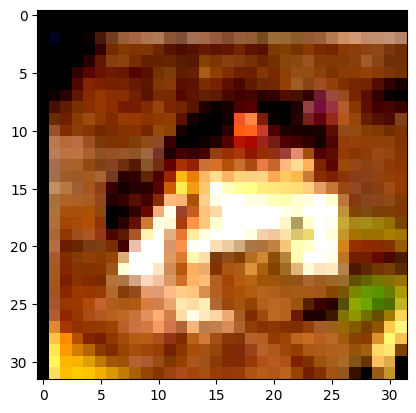

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


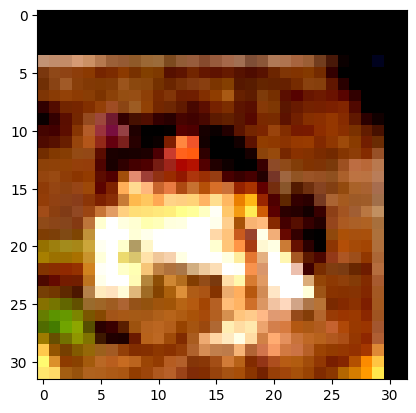

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


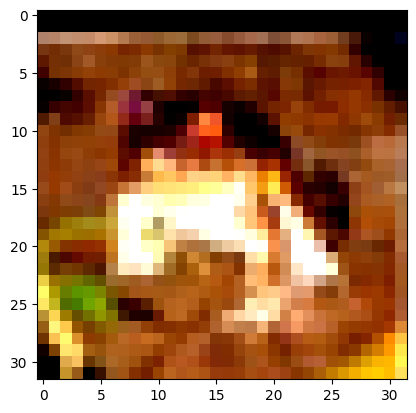

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


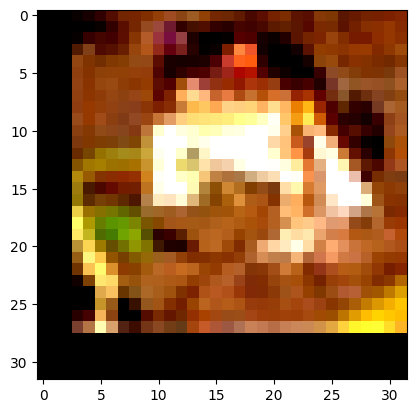

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


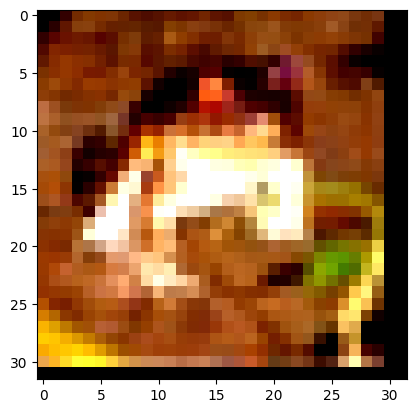

In [17]:
for i in range(5):
    x, y = next(iter(trainset))
    img = 0.5 * (x.numpy().transpose((1, 2, 0))) + 0.5
    # You can perform additional processing or display each image as needed
    plt.imshow(img)
    plt.show()

## Random Neural Network Setup

In [4]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
net = CustomCNN()
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training

In [6]:
for epoch in range(50):  # number of epochs
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')


Epoch 1, Loss: 1.508025494835261
Epoch 2, Loss: 1.0930607010184041
Epoch 3, Loss: 0.9199400095988417
Epoch 4, Loss: 0.8250388051847668
Epoch 5, Loss: 0.7613363525904048
Epoch 6, Loss: 0.708923135343415
Epoch 7, Loss: 0.6769303269779591
Epoch 8, Loss: 0.6455822332816965
Epoch 9, Loss: 0.6111828923377844
Epoch 10, Loss: 0.5890200173344149
Epoch 11, Loss: 0.5698087057646584
Epoch 12, Loss: 0.5527678223522118
Epoch 13, Loss: 0.5406649121847908
Epoch 14, Loss: 0.5232573428269848
Epoch 15, Loss: 0.5065447965736889
Epoch 16, Loss: 0.49238229933602123
Epoch 17, Loss: 0.4841849647481423
Epoch 18, Loss: 0.47535320163687783
Epoch 19, Loss: 0.4672748613959688
Epoch 20, Loss: 0.45540060036246427
Epoch 21, Loss: 0.44513539333477653
Epoch 22, Loss: 0.4347479004231865
Epoch 23, Loss: 0.4256881573773406
Epoch 24, Loss: 0.41918924308913136
Epoch 25, Loss: 0.4143306012348751
Epoch 26, Loss: 0.4083933582734269
Epoch 27, Loss: 0.40850130897348796
Epoch 28, Loss: 0.4020303018067194
Epoch 29, Loss: 0.3915346

## Evaluation

In [7]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

Accuracy of the network on the 10000 test images: 83%


## RestNet Setup

In [8]:
model = timm.create_model('resnet18', pretrained=True, num_classes=10)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


model.safetensors: 100%|██████████| 46.8M/46.8M [00:00<00:00, 67.1MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## ResNet Training

In [10]:
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")
    wandb.log({"epoch": epoch, "loss": running_loss / len(trainloader)})

Epoch 1, Loss: 1.1377209949371454
Epoch 2, Loss: 0.7458720812026192
Epoch 3, Loss: 0.6317750746026978
Epoch 4, Loss: 0.5765973026185389
Epoch 5, Loss: 0.5300384078679792
Epoch 6, Loss: 0.4941581780724513
Epoch 7, Loss: 0.4643797157784862
Epoch 8, Loss: 0.4437205498785619
Epoch 9, Loss: 0.41865230759467614
Epoch 10, Loss: 0.3987567126750946
Epoch 11, Loss: 0.3860734920100788
Epoch 12, Loss: 0.3684083410464894
Epoch 13, Loss: 0.3549149795756925
Epoch 14, Loss: 0.33744675582250977
Epoch 15, Loss: 0.32777072219630643
Epoch 16, Loss: 0.3119006521923615
Epoch 17, Loss: 0.30638740273654613
Epoch 18, Loss: 0.293659752696905
Epoch 19, Loss: 0.28353304934242496
Epoch 20, Loss: 0.27502823119883035
Epoch 21, Loss: 0.26597439697788805
Epoch 22, Loss: 0.25499531740079756
Epoch 23, Loss: 0.24780592571972582
Epoch 24, Loss: 0.24000720584484012
Epoch 25, Loss: 0.2341171384591352
Epoch 26, Loss: 0.22712254785287106
Epoch 27, Loss: 0.22908033860747315
Epoch 28, Loss: 0.21682901822907083
Epoch 29, Loss: 0

## RestNet Evaluation

In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    wandb.log({"test_accuracy": 100 * correct // total})
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')


Accuracy of the network on the 10000 test images: 86%


In [12]:
wandb.watch(model, log='all')


[]

In [13]:
torch.save(model.state_dict(), 'model.pth')
wandb.save('model.pth')


['/tmp/wandb/run-20231210_213208-95y2p0s2/files/model.pth']